# Predicting rate of death
The CDC [reports](https://www.kaggle.com/datasets/cdc/nchs-death-rates-and-causes-of-death) death rates in all US states due to various causes such as heart disease, Alzheimer's, etc.

This notebook is an effort to find the features which predict those rates. I am using [Census Bureau nonemployer establishment data](https://www.census.gov/programs-surveys/nonemployer-statistics/data/datasets.html#:~:text=Nonemployer%20Statistics%20Datasets,-Nonemployer%20Statistics%20(NES&text=NES%20data%20includes%20the%20number,geographic%20area%20and%20industry%20detail.) as my first attempt. A nonemployer estabishment is a business without any employees.

Death rates are measured as the number of deaths per 100,000 people.

The data is for year 2017.

This is a work-in-progress. I have gotten as far as:
* Preparing the feature set.
* Running a multiple linear regression for heart disease.
* [Reaching a conclusion](#heart_disease_linear_regression_conclusion).

My next steps are to apply these models:
* Naive Bayes.
* Decision trees (with [XGBoost](https://xgboost.readthedocs.io/en/stable/)).

In [104]:
import collections
import csv
import datetime
import itertools
import math
import os
import pickle
import re
import subprocess
# Imports above are standard library
# Imports below are 3rd-party
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, recall_score, precision_score, silhouette_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.api import qqplot
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
from xgboost import XGBClassifier, plot_importance

## Kaggle API
You will need your own API key, which you can get by following instructions at https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md

In [105]:
os.environ["KAGGLE_USERNAME"] = "jsf80238"
os.environ["KAGGLE_KEY"] = "4036359324650e1c13adfc7ba87ff90e"
import kaggle  # The import itself uses your KAGGLE_KEY, that's why the import is not at the top. Really.

dataset_name = "NCHS - Death Rates and Causes of Death"
command = "kaggle datasets list --csv --search".split()
#command.append("NCHS - Death Rates and Causes of Death")
result = subprocess.run(command + [dataset_name], capture_output=True)
data = result.stdout.decode(encoding="utf-8")
data[:100]

'ref,title,size,lastUpdated,downloadCount,voteCount,usabilityRating\r\ncdc/nchs-death-rates-and-causes-'

In [106]:
csvreader = csv.DictReader(data.splitlines())
for row in csvreader:
    if row["title"] == dataset_name:
        print(row)
        dataset_ref = row['ref']
        break
dataset_ref

{'ref': 'cdc/nchs-death-rates-and-causes-of-death', 'title': 'NCHS - Death Rates and Causes of Death', 'size': '3MB', 'lastUpdated': '2019-12-28 01:24:17', 'downloadCount': '1571', 'voteCount': '14', 'usabilityRating': '0.7647059'}


'cdc/nchs-death-rates-and-causes-of-death'

In [107]:
dataset_ref = "cdc/nchs-death-rates-and-causes-of-death"
file_name = "nchs-leading-causes-of-death-united-states.csv"
command = f"kaggle datasets download --unzip --force --file {file_name} {dataset_ref}".split()
result = subprocess.run(command, capture_output=True)
stdout = result.stdout.decode(encoding="utf-8")
stderr = result.stderr.decode(encoding="utf-8")
print(stdout)
print(stderr)
print(os.linesep.join(sorted(os.listdir("."))))

Dataset URL: https://www.kaggle.com/datasets/cdc/nchs-death-rates-and-causes-of-death
License(s): other


100%|██████████| 834k/834k [00:00<00:00, 2.96MB/s]

.ipynb_checkpoints
census.df
death_rate.ipynb
death_rate_previous_code.ipynb
nchs-age-adjusted-death-rates-for-selected-major-causes-of-death.csv
nchs-leading-causes-of-death-united-states.csv
nchs-leading-causes-of-death-united-states.df
socrata_metadata_nchs-age-adjusted-death-rates-for-selected-major-causes-of-death.json
socrata_metadata_nchs-death-rates-and-life-expectancy-at-birth.json
socrata_metadata_nchs-leading-causes-of-death-united-states.json
socrata_metadata_nchs-potentially-excess-deaths-from-the-five-leading-causes-of-death.json
socrata_metadata_nchs-top-five-leading-causes-of-death-united-states-1990-1950-2000.json


### Kaggle workaround
If you were unable to download the cause-of-death file you can also grab it from my GitHub repo:

https://github.com/jsf80238/data_science/blob/main/data_files/nchs-leading-causes-of-death-united-states.csv

In [108]:
df = pd.read_csv(file_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     10868 non-null  int64  
 1   113 Cause Name           10868 non-null  object 
 2   Cause Name               10868 non-null  object 
 3   State                    10868 non-null  object 
 4   Deaths                   10868 non-null  int64  
 5   Age-adjusted Death Rate  10868 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 509.6+ KB


In [109]:
save_file = "nchs-leading-causes-of-death-united-states.df"
# with open(save_file, "wb") as writer:
#     pickle.dump(df, writer)

with open(save_file, "rb") as reader:
    df = pickle.load(reader)

print(f"{df.shape[0]:,} rows")
df.head(2)

10,868 rows


,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2012,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,21,2.6
1,2017,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,29,3.3


### Exploratory data analysis
Use [data profiling tool](https://github.com/jsf80238/data_science/blob/main/README.md) to do this.

Download this dataframe to CSV:
```
save_file = "nchs-leading-causes-of-death-united-states.csv"
with open(save_file, "w") as writer:
    writer.write(df.to_csv(index=False))
print(f"Wrote {os.stat(save_file).st_size} bytes to '{save_file}'.")
```
Analyze using the tool.
```
~/PycharmProjects/data_science $ python data_science/profile_data.py data_files/nchs-leading-causes-of-death-united-states.csv --tar=$HOME
```

Results below.

#### Summary

![summary](../images/death_rate/summary.png)

Of note above:
* Columns C & D tell us we have no nulls.
* Cells I2 and J2 tell us we have data from years 1999 to 2017.
* Cells E5, I5, J5 and K5 tell us we have all the states plus Washington DC. Actually we have one too many, we'll have to see why that is.
* Cells I7 & J7 say there is a very wide range for adjusted death rate, we'll have to see why that is.

#### Years

![summary](../images/death_rate/year_box.png)

(Looks good.)

#### Cause (of death)

![summary](../images/death_rate/cause_detail.png)

(Looks good.)

#### Death rate

![summary](../images/death_rate/death_rate_box.png)

Outliers. See below for what we do with those.

#### Duplicate data
Next, check for duplicate data.

In [110]:
df.duplicated().value_counts()

False    10868
Name: count, dtype: int64

In [111]:
### 52 states?

In [112]:
df["State"].value_counts().reset_index().sort_values(by=["State"])

,State,count
21,Alabama,209
39,Alaska,209
29,Arizona,209
51,Arkansas,209
37,California,209
50,Colorado,209
43,Connecticut,209
26,Delaware,209
1,District of Columbia,209
40,Florida,209


## Adjustments
The data includes rows for deaths for the entire United States, we don't want those.

Also, in case 2017 was an especially good or bad year, use the average from 2010-2017.

Also, drop unneeded columns.

In [113]:
name_dict = {
    "Year": "year",
    "Cause Name": "cause",
    "State": "state_name",
    "Age-adjusted Death Rate": "death_rate",
}
df.rename(columns=name_dict, inplace=True)

df.drop(columns=["113 Cause Name", "Deaths"], inplace=True)

mask = (df["year"] >= 2010) & (df["state_name"] != 'United States')
df = df[mask]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4488 entries, 0 to 10802
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        4488 non-null   int64  
 1   cause       4488 non-null   object 
 2   state_name  4488 non-null   object 
 3   death_rate  4488 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 175.3+ KB


### Ultimately we want death rate by state and cause

In [114]:
df = df[["state_name", "cause", "death_rate"]].groupby(["state_name", "cause"]).mean().reset_index()
df

,state_name,cause,death_rate
0,Alabama,All causes,924.6125
1,Alabama,Alzheimer's disease,35.2625
2,Alabama,CLRD,55.5750
3,Alabama,Cancer,180.5125
4,Alabama,Diabetes,22.6875
...,...,...,...
556,Wyoming,Influenza and pneumonia,17.5750
557,Wyoming,Kidney disease,11.7625
558,Wyoming,Stroke,33.2625
559,Wyoming,Suicide,24.6750


## Add a normalized death rate
A state may have a higher death rate across-the-board, or may have a higher death rate for particular causes, or both.

Divide the death rates for particular causes by the death rate for that state to better isolate particular causes.

In [115]:
death_rate_all_causes = "death_rate_all_causes"
all_causes = "All causes"
mask = (df["cause"] == all_causes)
by_state_df = df[mask][["state_name", "death_rate"]]
print(f"{by_state_df.shape[0]:,} rows")
by_state_df.head(2)

51 rows


,state_name,death_rate
0,Alabama,924.6125
11,Alaska,739.2125


In [116]:
df = df.merge(by_state_df, on="state_name", suffixes=(None, "_all_causes"))
df["death_rate_normalized"] = df["death_rate"] / df[death_rate_all_causes]
df.drop(columns=[death_rate_all_causes], inplace=True)
print(f"{df.shape[0]:,} rows")
df.head(2)

561 rows


,state_name,cause,death_rate,death_rate_normalized
0,Alabama,All causes,924.6125,1.000000
1,Alabama,Alzheimer's disease,35.2625,0.038138


### We don't need all-causes rows anymore

In [117]:
mask = (df["cause"] != all_causes)
df = df[mask]
print(f"{df.shape[0]:,} rows")
df.head(2)

510 rows


,state_name,cause,death_rate,death_rate_normalized
1,Alabama,Alzheimer's disease,35.2625,0.038138
2,Alabama,CLRD,55.5750,0.060106


## Census data: state populations

In [118]:
CENSUS_API_KEY = "35b2edd7f868b6d6f79e5988091d0f8df6ffbd2a"

In [119]:
CENSUS_DEMOGRAPHICS_URL = "https://api.census.gov/data/2019/pep/charagegroups"
param_dict = {'get': 'NAME,POP', 'for': 'state:*', "key": CENSUS_API_KEY}

In [120]:
response = requests.get(CENSUS_DEMOGRAPHICS_URL, params=param_dict)

In [121]:
result_list = response.json()  # The return from the API call is a list of lists, with first item being the column names
column_name_list = result_list.pop(0)
states_df = pd.DataFrame(result_list, columns=column_name_list)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    52 non-null     object
 1   POP     52 non-null     object
 2   state   52 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


<a id='states_by_id'></a>

In [122]:
name_dict = {
    "NAME": "state_name",
    "POP": "population",
    "state": "state_key",
}
states_df.rename(columns=name_dict, inplace=True)
states_df["population"] = states_df["population"].astype(int)
states_df["state_key"] = states_df["state_key"].astype(int)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state_name  52 non-null     object
 1   population  52 non-null     int64 
 2   state_key   52 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


In [123]:
states_df["population"].sum()  # Expected value ~330 million

331433217

In [124]:
df = df.merge(states_df, on="state_name", how="inner")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state_name             510 non-null    object 
 1   cause                  510 non-null    object 
 2   death_rate             510 non-null    float64
 3   death_rate_normalized  510 non-null    float64
 4   population             510 non-null    int64  
 5   state_key              510 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 24.0+ KB


## Census data: non-employer data
Nonemployer Statistics provides annual statistics on U.S. businesses with no paid employees or payroll at a detailed geography and industry level.

Statistics are available on businesses that have no paid employment or payroll, are subject to federal income taxes, and have receipts of \\$1,000 or more (\\$1 or more for the Construction sector). The data are available for approximately 450 NAICS industries at the national, state, county, metropolitan statistical area, and combined statistical area geography levels. The majority of NAICS industries are included.

https://www.census.gov/data/developers/data-sets/nonemp-api.2017.html#list-tab-1358655114

https://www.census.gov/data/developers/data-sets/nonemp-api.html
https://api.census.gov/data/2017/nonemp/variables.html

https://www2.census.gov/programs-surveys/nonemployer-statistics/technical-documentation/record-layouts/state-record-layout/state_record_layout_2017.txt

### Definitions
* LFO = Legal form of organization
* NAICS2017_LABEL = type of business
* NAME = geo areas, including states
* NESTAB = Number of nonemployer establishments
* NRCPTOT = Nonemployer sales, value of shipments, or revenue ($1,000)
* RCPSZES_LABEL = Separates establishments into groups by sales/receipts, including "All establishments"

In [125]:
CENSUS_NONEMPLOYER_URL = "https://api.census.gov/data/2017/nonemp"
param_dict = {'get': ','.join(("LFO", "NESTAB", "NRCPTOT")), 'for': 'state:*', "NAICS2017": '*', "key": CENSUS_API_KEY}

In [126]:
save_file = "census.df"
# with open(save_file, "wb") as writer:
#     pickle.dump(business_df, writer)

with open(save_file, "rb") as reader:
    business_df = pickle.load(reader)

business_df

,LFO,NESTAB,NRCPTOT,NAICS2017,state
0,001,219596,8889009,00,28
1,9101,1750,206357,00,28
2,9111,6527,848178,00,28
3,920,198380,6220549,00,28
4,930,12939,1613925,00,28
...,...,...,...,...,...
109376,001,4930,58618,813,18
109377,9101,49,1913,813,18
109378,9111,9,360,813,18
109379,920,4864,56215,813,18


### Exploratory data analysis
Download this dataframe to CSV:
```
save_file = "nonemployee-data.csv"
with open(save_file, "w") as writer:
    writer.write(business_df.to_csv(index=False))
print(f"Wrote {os.stat(save_file).st_size} bytes to '{save_file}'.")
```
Use the [data profiling tool](https://github.com/jsf80238/data_science/blob/main/README.md).
```
~/PycharmProjects/data_science $ python data_science/profile_data.py data_files/nonemployee-data.csv --tar=$HOME
```

Results below.

#### Summary

![summary](../images/death_rate/non_employer_summary.png)

Of note above:
* Cell E2 tells us we have 51 states ... might be 50 plus DC, might be 50 plus United States, we'll have to check.
* The _largest_, _smallest_, _mean_ and _standard deviation_ measures for the number of establishments and total receipts show abnormally large values.

#### State

![summary](../images/death_rate/non_employer_state.png)

The _value_ column contains the state ID ... refer to [this cell](#states_by_id) for the lookup. We still have to verify we have the correct 51.

#### Legal Form of Establishment

![summary](../images/death_rate/non_employer_legal_form.png)

Roughly an even split, which is not unreasonable. The [lookup table](../data_files/legal_form_codes.csv) tells us we will need to remove the _1.0/All_ rows.

#### Number of establishments

![summary](../images/death_rate/non_employer_number_of_establishments.png)

There are a lot with a value of 0, but probably reasonable that in a given state there might be zero such establishments for certain combinations of legal form and business type (for example, 486110/Pipeline Transportation of Crude Oil in Rhode Island).

#### Revenue

![summary](../images/death_rate/non_employer_revenue.png)

Outliers, will need to investigate that.

#### NAICS code

![summary](../images/death_rate/non_employer_naics_code.png)

The [lookup table](../data_files/naics_codes.csv) tells us the NAICS codes will be 2, 3, 4, 5 or 6 digits depending on the level in the hierarchy, but the pattern breakdown from the actual data shows some codes which are not all digits: `99?99`. We will need to investigate that.

#### Duplicate data
Next, check for duplicate data.

In [127]:
business_df.duplicated().value_counts()

False    109381
Name: count, dtype: int64

### Cleanup
* Give columns better names
* Convert numeric-like values to numerics

In [128]:
name_dict = {
    "state": "state_key",
    "NAICS2017": "business_type",
    "LFO": "legal_form",
    "NESTAB": "establishment_count",
    "NRCPTOT": "revenue_in_thousands",
}
business_df.rename(columns=name_dict, inplace=True)
business_df = business_df.reindex(["state_key", "legal_form", "business_type", "establishment_count", "revenue_in_thousands"], axis=1)

for column_name in "establishment_count", "revenue_in_thousands", "state_key":
    business_df[column_name] = business_df[column_name].astype(int)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109381 entries, 0 to 109380
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   state_key             109381 non-null  int64 
 1   legal_form            109381 non-null  object
 2   business_type         109381 non-null  object
 3   establishment_count   109381 non-null  int64 
 4   revenue_in_thousands  109381 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.2+ MB


### Revenue and number of establishments outliers

In [129]:
business_df["revenue_in_thousands"].value_counts().reset_index().sort_values(by="revenue_in_thousands").tail()

,revenue_in_thousands,count
28191,92939642,1
35416,98320439,1
35552,118091482,1
28736,118273287,1
35555,181655457,1


In [130]:
mask = (business_df["revenue_in_thousands"] >= 118273287)
business_df[mask]

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
8627,48,001,00,2399267,118273287
34088,6,001,00,3374050,181655457


### Eliminate summary rows
Rows where the legal_form is '001' or the business_type is '00' are summaries of the other rows, we don't want them.

In [131]:
mask = (business_df["legal_form"] != "001") & (business_df["business_type"] != '00')
business_df = business_df[mask]
business_df.shape

(85351, 5)

### NAICS codes unexpected data
Our exploratory data analysis showed rows where the NAICS code (now named _business_type_ was of the form:

`digit digit something digit digit`

whereas we expected all digits.

In [132]:
mask = (business_df["business_type"].str.isnumeric())
business_df[~mask]

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
245,28,9101,31-33,52,5329
246,28,9111,31-33,150,17001
247,28,920,31-33,2286,73289
248,28,930,31-33,134,13047
630,28,9101,44-45,147,23219
...,...,...,...,...,...
99210,19,930,48-49,421,62485
99388,20,9101,48-49,82,10752
99389,20,9111,48-49,281,40480
99390,20,920,48-49,10152,657010


## Census codes
It will be helpful for further analysis to be able to view the legal form codes and business type codes as strings rather than codes.

I've gone to the trouble of downloading these, because the Census people don't make this information easy to work with (see the Original links below).
* North American Industry Classification System (aka NAIC)
  * [Original](https://www.census.gov/naics/?58967?yearbck=2017)
  * [Version used here](https://github.com/jsf80238/data_science/blob/main/data_files/naics_codes.csv)
* Legal Form of Organization
  * [Original](https://www2.census.gov/programs-surveys/abs/technical-documentation/api/NESD-Technical-Employer-and-Nonemployer-API-5242022Final.pdf)
  * [Version used here](https://github.com/jsf80238/data_science/blob/main/data_files/legal_form_codes.csv)

In [133]:
def reformat_column_name(s: str) -> str:
    s = re.sub(r"\W", "_", s)
    s = s.replace("__", "_")
    s = re.sub(r"_$", "", s)
    return s.lower()


BUSINESS_TYPE_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/naics_codes.csv"
response = requests.get(BUSINESS_TYPE_URL)
line_list = response.text.splitlines()

business_type_dict = dict()
csvreader = csv.DictReader(line_list)
label_for_keys, label_for_values = csvreader.fieldnames
for row in csvreader:
    nominal_label = row[label_for_values]
    improved_label = reformat_column_name(nominal_label)
    business_type_dict[row[label_for_keys]] = improved_label


LEGAL_FORM_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/legal_form_codes.csv"
response = requests.get(LEGAL_FORM_URL)
line_list = response.text.splitlines()

legal_form_dict = dict()
csvreader = csv.DictReader(line_list)
label_for_keys, label_for_values = csvreader.fieldnames
for row in csvreader:
    nominal_label = row[label_for_values]
    improved_label = reformat_column_name(nominal_label)
    legal_form_dict[row[label_for_keys]] = improved_label


In [134]:
for key, value in business_type_dict.items():
    if "-" in key:
        print(key, value)


31-33 manufacturing
44-45 retail_trade
48-49 transportation_and_warehousing


In [135]:
# Verify there are no rows with a code of 31, 32, 33, 44, 45, 48 or 49
mask = (business_df["business_type"].isin((31, 32, 33, 44, 45, 48, 49)))
business_df[mask].shape

(0, 5)

There are none.

## Keep only the useful business type rows
The Census data contains rows for multiple levels, some of which are summaries of levels below, for example:
| Code | Name |
| --- | --- |
| 11 | Agriculture, Forestry, Fishing and Hunting |
| 111 | Crop Production |
| 1111 | Oilseed and Grain Farming |
| 11111 | Soybean Farming |
| 111110 | Soybean Farming |
| 11112 | Oilseed (except Soybean) Farming |
| 111120 | Oilseed (except Soybean) Farming |
| 11113 | Dry Pea and Bean Farming |
| 111130 | Dry Pea and Bean Farming |
| ... | ... |
| 115210 | Support Activities for Animal Production |
| 1153 | Support Activities for Forestry |
| 11531 | Support Activities for Forestry |
| 115310 | Support Activities for Forestry |
| 21 | Mining |  Quarrying |  and Oil and Gas Extraction |
| 211 | Oil and Gas Extraction |
| 2111 | Oil and Gas Extraction |
| 21112 | Crude Petroleum Extraction  |

Although somewhat arbitrary, the 2-digit codes make the most sense to me.

And we need to include codes with dashes, because those will be treated as two-digit codes.

In [137]:
mask = (business_df["business_type"].str.len() == 2) | (business_df["business_type"].str.contains("-"))
business_df = business_df[mask]
print(business_df.shape)
business_df.head(2)

(3665, 5)


,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
6,28,9101,11,77,10091
7,28,9111,11,176,20417


### Check for duplicates

In [138]:
mask = business_df[["state_key", "business_type", "legal_form"]].duplicated()
business_df[mask]

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands


## Check for holes
Verify this data does not have holes, meaning verify every combination of legal_form/business_type exists for every state.

If something is missing, add it with np.nan for the establishment_count and revenue.

In [139]:
state_list = business_df["state_key"].unique()
legal_form_list = business_df["legal_form"].unique()
business_type_list = business_df["business_type"].unique()
wanted_combinations_set = set(itertools.product(state_list, legal_form_list, business_type_list))
print(f"{len(wanted_combinations_set):,} possible combinations, for example:")
for i, item in enumerate(wanted_combinations_set):
    print(item)
    if i > 10:
        break


3,672 possible combinations, for example:
(15, '9111', '71')
(35, '920', '71')
(18, '920', '62')
(8, '9101', '56')
(21, '920', '54')
(31, '920', '11')
(33, '930', '54')
(30, '930', '22')
(42, '9101', '48-49')
(48, '930', '48-49')
(44, '930', '44-45')
(25, '930', '31-33')


In [140]:
existing_combinations_set = set()
for item in business_df[["state_key", "legal_form", "business_type"]].to_records(index=False):
    existing_combinations_set.add(tuple(item))
print(f"{len(existing_combinations_set):,} existing combinations, for example:")
for i, item in enumerate(existing_combinations_set):
    print(item)
    if i > 10:
        break

3,665 existing combinations, for example:
(15, '9111', '71')
(35, '920', '71')
(18, '920', '62')
(8, '9101', '56')
(21, '920', '54')
(31, '920', '11')
(33, '930', '54')
(30, '930', '22')
(42, '9101', '48-49')
(48, '930', '48-49')
(44, '930', '44-45')
(25, '930', '31-33')


In [141]:
missing_combinations_set = wanted_combinations_set - existing_combinations_set
print(f"{len(missing_combinations_set):,} missing combinations, for example:")
for i, item in enumerate(missing_combinations_set):
    print(item)
    if i > 10:
        break

7 missing combinations, for example:
(44, '9101', '21')
(11, '9111', '21')
(11, '9101', '22')
(11, '930', '21')
(11, '9101', '21')
(2, '9111', '22')
(11, '9111', '11')


In [142]:
missing_data = [list(combo) + [np.nan, np.nan] for combo in missing_combinations_set]
missing_data[:10]

[[44, '9101', '21', nan, nan],
 [11, '9111', '21', nan, nan],
 [11, '9101', '22', nan, nan],
 [11, '930', '21', nan, nan],
 [11, '9101', '21', nan, nan],
 [2, '9111', '22', nan, nan],
 [11, '9111', '11', nan, nan]]

In [143]:
missing_df = pd.DataFrame.from_records(missing_data)
missing_df.columns = ["state_key", "legal_form", "business_type", "establishment_count", "revenue_in_thousands"]
missing_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,44,9101,21,NaN,NaN
1,11,9111,21,NaN,NaN
2,11,9101,22,NaN,NaN
3,11,930,21,NaN,NaN
4,11,9101,21,NaN,NaN
5,2,9111,22,NaN,NaN
6,11,9111,11,NaN,NaN


In [144]:
business_df = pd.concat([business_df, missing_df], ignore_index=True)
business_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,28,9101,11,77.0,10091.0
1,28,9111,11,176.0,20417.0
2,28,920,11,3692.0,165982.0
3,28,930,11,182.0,19481.0
4,28,9101,21,20.0,1993.0
...,...,...,...,...,...
3667,11,9101,22,NaN,NaN
3668,11,930,21,NaN,NaN
3669,11,9101,21,NaN,NaN
3670,2,9111,22,NaN,NaN


## Merge cause of death data with business data

In [145]:
df = df.merge(business_df, on="state_key", how="inner")
print(f"{df.shape[0]:,} rows")
df.head(2)

36,720 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,11,30.0,4246.0
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,11,146.0,27390.0


## Adjust for population
We would expect the number of establishments and revenue to be higher in more populous states.

Adjust.

In [146]:
df["establishments_per_person"] = df["establishment_count"] / df["population"]
df["revenue_per_person"] = df["revenue_in_thousands"] * 1000 / df["population"]
df["revenue_per_establishment"] = df["revenue_in_thousands"] * 1000 / df["establishment_count"]
print(f"{df.shape[0]:,} rows")
df.head(2)

36,720 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,11,30.0,4246.0,0.000006,0.865968,141533.333333
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,11,146.0,27390.0,0.000030,5.586165,187602.739726


## Categorization of data
Let's make population, establishment_per_person and revenue_per_person categories

Distribution plots will help us decide how to make the cuts.

7 for population.
30 for establishments_per_person.
30 for revenue_per_establishment.


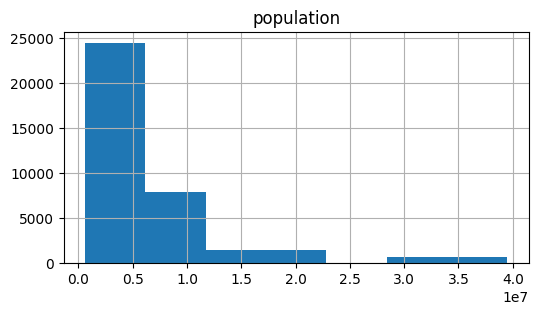

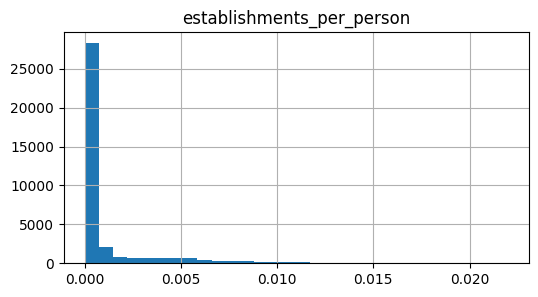

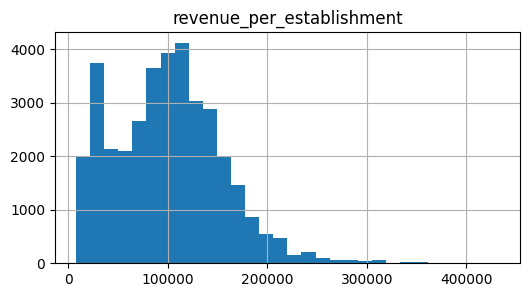

In [147]:
for column_name in "population", "establishments_per_person", "revenue_per_establishment":
    number_of_observations = df[column_name].nunique()
    # Rice's rule
    suggested_bin_count = int(math.cbrt(number_of_observations)*2)
    print(f"{suggested_bin_count} for {column_name}.")
    df.hist(column=column_name, bins=suggested_bin_count, figsize=(6, 3))

### Binning conclusion
Population: 7 cuts based on absolute population

Establishments and revenue per establishment: 7 cuts with equal numbers of observations in each bin

In [148]:
XXSMALL = "xx-small"
XSMALL = "x-small"
SMALL = "small"
MEDIUM = "medium"
LARGE = "large"
XLARGE = "x-large"
XXLARGE = "xx-large"

df["population_bin"] = pd.cut(df["population"], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
df["establishments_bin"] = pd.qcut(df["establishments_per_person"], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
df["revenue_per_establishment_bin"] = pd.qcut(df["revenue_per_establishment"], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])

for column_name in "population_bin", "establishments_bin", "revenue_per_establishment_bin":
    print(df[column_name].value_counts())

print(f"{df.shape[0]:,} rows")
df.head(2)

population_bin
xx-small    24480
x-small      7920
small        1440
medium       1440
x-large       720
xx-large      720
large           0
Name: count, dtype: int64
establishments_bin
xx-small    5240
x-small     5240
medium      5240
x-large     5240
small       5230
large       5230
xx-large    5230
Name: count, dtype: int64
revenue_per_establishment_bin
xx-small    5200
small       5200
large       5200
x-small     5190
medium      5190
x-large     5190
xx-large    5190
Name: count, dtype: int64
36,720 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,11,30.0,4246.0,0.000006,0.865968,141533.333333,xx-small,xx-small,x-large
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,11,146.0,27390.0,0.000030,5.586165,187602.739726,xx-small,x-small,xx-large


## Set establishments and revenue to 0/XXSMALL where currently NaN
These did not exist at all in the original data, meaning their true value is zero and  XXSMALL is a good bin/category.

Also, delete no-longer-needed columns.

In [149]:
df["establishments_bin"] = df["establishments_bin"].fillna(XXSMALL)
df["revenue_per_establishment_bin"] = df["revenue_per_establishment_bin"].fillna(XXSMALL)
df["revenue_per_establishment"] = df["revenue_per_establishment"].fillna(0)
df["establishments_per_person"] = df["establishments_per_person"].fillna(0)

df.drop(columns=["state_key", "state_name", "establishment_count"], inplace=True)

print(f"{df.shape[0]:,} rows")
df.head(2)

36,720 rows


,cause,death_rate,death_rate_normalized,population,legal_form,business_type,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,9101,11,4246.0,0.000006,0.865968,141533.333333,xx-small,xx-small,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,9111,11,27390.0,0.000030,5.586165,187602.739726,xx-small,x-small,xx-large


## Categorize death rates
We need to do this for each cause of death, because they are not really comparable to each other.

7 for Alzheimer's disease.
7 for CLRD.
7 for Cancer.
7 for Diabetes.
7 for Heart disease.
7 for Influenza and pneumonia.
7 for Kidney disease.
7 for Stroke.
7 for Suicide.
7 for Unintentional injuries.


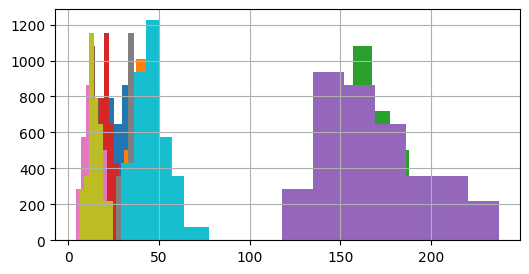

In [150]:
for cause_name in df["cause"].unique():
    mask = (df["cause"] == cause_name)
    number_of_observations = df[mask]["death_rate"].nunique()
    # Rice's rule
    suggested_bin_count = int(math.cbrt(number_of_observations)*2)
    print(f"{suggested_bin_count} for {cause_name}.")
    df[mask]["death_rate"].hist(bins=suggested_bin_count, figsize=(6, 3))

In [151]:
try:
    df.drop(columns=["death_rate_bin"], inplace=True)
except KeyError:
    pass

all_labels_df = pd.DataFrame()

for cause_name in df["cause"].unique():
    mask = (df["cause"] == cause_name)
    cause_labels = pd.qcut(df[mask]["death_rate"], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
    if all_labels_df.size:
        all_labels_df = pd.concat([all_labels_df, cause_labels])
    else:
        all_labels_df = cause_labels

all_labels_df.shape

(36720,)

In [152]:
df = df.merge(all_labels_df, left_index=True, right_index=True, suffixes=(None, "_bin"))
print(df["death_rate_bin"].value_counts())
print(f"{df.shape[0]:,} rows")
df.head(2)

death_rate_bin
xx-small    5760
medium      5760
x-small     5040
small       5040
large       5040
x-large     5040
xx-large    5040
Name: count, dtype: int64
36,720 rows


,cause,death_rate,death_rate_normalized,population,legal_form,business_type,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,9101,11,4246.0,0.000006,0.865968,141533.333333,xx-small,xx-small,x-large,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,9111,11,27390.0,0.000030,5.586165,187602.739726,xx-small,x-small,xx-large,x-large


## Census codes
Up to now we've been using the census codes for
* business_type (e.g. '111' is "Crop Production") ... a/k/a NAIC code
* legal_form (e.g. '920' is "Individual Proprietor")

Convert these to the human-readable label.

In [153]:
df["legal_form"] = df["legal_form"].apply(lambda x: legal_form_dict.get(x))
print(f"{df.shape[0]:,} rows")

df["business_type"] = df["business_type"].apply(lambda x: business_type_dict.get(x))
print(f"{df.shape[0]:,} rows")

df.head(2)

36,720 rows
36,720 rows


,cause,death_rate,death_rate_normalized,population,legal_form,business_type,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,c_corp,agriculture_forestry_fishing_and_hunting,4246.0,0.000006,0.865968,141533.333333,xx-small,xx-small,x-large,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,s_corp,agriculture_forestry_fishing_and_hunting,27390.0,0.000030,5.586165,187602.739726,xx-small,x-small,xx-large,x-large


## More cleanup
* Scale numeric features.
* Convert legal_form and business_type to Pandas categories.
* Encode the categorical data to 0/1:
  * Legal form
  * Business type
  * Population
  * Establishments
  * Revenue


### Scaling
See https://www.simplilearn.com/normalization-vs-standardization-article.
* Normalization: centered on 0 with standard deviation of 1 (and no effect on outliers).
* Standardization: lowest/highest values become 0 and 1.

In [154]:
scaling_df = pd.DataFrame()

numeric_column_list = df.select_dtypes(include=["float64", "int64"]).columns
to_be_scaled_column_list = [x for x in numeric_column_list if not x.startswith("death")]
for column_name in to_be_scaled_column_list:
        scaling_df[column_name] = df[column_name].copy()

scaler = MinMaxScaler()
scaling_df = pd.DataFrame(scaler.fit_transform(scaling_df), columns=to_be_scaled_column_list)

scaling_df

,population,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment
0,0.111072,0.000155,0.000278,0.000745,0.327169
1,0.111072,0.001001,0.001355,0.004803,0.433663
2,0.111072,0.005528,0.037611,0.026535,0.086328
3,0.111072,0.001066,0.001671,0.005117,0.374750
4,0.111072,0.000008,0.000056,0.000039,0.085915
...,...,...,...,...,...
36715,0.000000,0.000436,0.007549,0.017739,0.287530
36716,0.000000,0.000138,0.004561,0.005603,0.150334
36717,0.000000,0.000469,0.012110,0.019073,0.192719
36718,0.000000,0.004670,0.454913,0.189908,0.051082


#### Add scaled columns to master dataframe

In [155]:
df = df.merge(scaling_df, left_index=True, right_index=True, suffixes=(None, "_scaled"))
print(f"{df.shape[0]:,} rows")
df.head(2)

36,720 rows


,cause,death_rate,death_rate_normalized,population,legal_form,business_type,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin,population_scaled,revenue_in_thousands_scaled,establishments_per_person_scaled,revenue_per_person_scaled,revenue_per_establishment_scaled
0,Alzheimer's disease,35.2625,0.038138,4903185,c_corp,agriculture_forestry_fishing_and_hunting,4246.0,0.000006,0.865968,141533.333333,xx-small,xx-small,x-large,x-large,0.111072,0.000155,0.000278,0.000745,0.327169
1,Alzheimer's disease,35.2625,0.038138,4903185,s_corp,agriculture_forestry_fishing_and_hunting,27390.0,0.000030,5.586165,187602.739726,xx-small,x-small,xx-large,x-large,0.111072,0.001001,0.001355,0.004803,0.433663


### Categorization

## Create revenue and establishments by legal form and business type
For example, suppose we have a row with these values:
* `establishments_per_person_scaled` = 0.123
* `revenue_per_establishment_scaled` = 0.456
* `legal_form` = 'c_corp'
* `business_type` = 'chemical_manufacturing'

That row will be updated to contain for example these columns (and many more columns for the many different legal forms and business types:
| air_transportation_</br>establishments_</br>per_person | air_transportation_</br>revenue_per_</br>establishment | chemical_manufacturing_</br>establishments_</br>per_person | chemical_manufacturing_</br>revenue_per_</br>establishment | gasoline_stations_</br>establishments_</br>per_person | gasoline_stations_</br>revenue_per_</br>establishment | c_corp_</br>establishments_</br>per_person | c_corp_</br>revenue_per_</br>establishment | partnership_</br>establishments_</br>per_person | partnership_</br>revenue_per_</br>establishment | 
| - | - | - | - | - | - | - | - | - | - |
| 0 | 0 | 0.123 | 0.456 | 0 | 0 | 0.123 | 0.456 | 0 | 0 |

In [156]:
df = pd.get_dummies(df, columns=["legal_form", "business_type"], dtype=int)
df.head(2)

,cause,death_rate,death_rate_normalized,population,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment,population_bin,establishments_bin,...,business_type_information,business_type_manufacturing,business_type_mining_quarrying_and_oil_and_gas_extraction,business_type_other_services_except_public_administration,business_type_professional_scientific_and_technical_services,business_type_real_estate_and_rental_and_leasing,business_type_retail_trade,business_type_transportation_and_warehousing,business_type_utilities,business_type_wholesale_trade
0,Alzheimer's disease,35.2625,0.038138,4903185,4246.0,0.000006,0.865968,141533.333333,xx-small,xx-small,...,0,0,0,0,0,0,0,0,0,0
1,Alzheimer's disease,35.2625,0.038138,4903185,27390.0,0.000030,5.586165,187602.739726,xx-small,x-small,...,0,0,0,0,0,0,0,0,0,0


### Add columns

In [157]:
establishments_per_person = "establishments_per_person"
revenue_per_establishment = "revenue_per_establishment"
business_type = "business_type"
legal_form = "legal_form"
scaled = "scaled"

column_list = list(df.columns)
legal_form_list = [x for x in column_list if x.startswith(legal_form)]
business_type_list = [x for x in column_list if x.startswith(business_type)]

In [158]:
for item in legal_form_list:
    establishments_column_name = item + "_" + establishments_per_person
    df[establishments_column_name] = df[establishments_per_person + "_" + scaled] * df[item]
    revenue_column_name = item + "_" + revenue_per_establishment
    df[revenue_column_name] = df[revenue_per_establishment + "_" + scaled] * df[item]

In [159]:
for item in business_type_list:
    establishments_column_name = item + "_" + establishments_per_person
    df[establishments_column_name] = df[establishments_per_person + "_" + scaled] * df[item]
    revenue_column_name = item + "_" + revenue_per_establishment
    df[revenue_column_name] = df[revenue_per_establishment + "_" + scaled] * df[item]

### Performance warning & cleanup
We'll take care of the `PerformanceWarning: DataFrame is highly fragmented.` warning in a bit. See https://stackoverflow.com/questions/68292862/performancewarning-dataframe-is-highly-fragmented-this-is-usually-the-result-o.

In the meantime, we no longer need the "dummies" columns, for example:
* legal_form_s_corp
* business_type_accommodation

In [160]:
columns_to_drop_list = list()
for column_name in df.columns:
    if column_name.startswith(legal_form) or column_name.startswith(business_type):
        if not column_name.endswith(establishments_per_person) and not column_name.endswith(revenue_per_establishment):
            columns_to_drop_list.append(column_name)
df.drop(columns=columns_to_drop_list, inplace=True)
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36720 entries, 0 to 36719
Data columns (total 61 columns):
 #   Column                                                                                                            Non-Null Count  Dtype   
---  ------                                                                                                            --------------  -----   
 0   cause                                                                                                             36720 non-null  object  
 1   death_rate                                                                                                        36720 non-null  float64 
 2   death_rate_normalized                                                                                             36720 non-null  float64 
 3   population                                                                                                        36720 non-null  int64   
 4   revenue_in_thousands  

,cause,death_rate,death_rate_normalized,population,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment,population_bin,establishments_bin,...,business_type_real_estate_and_rental_and_leasing_establishments_per_person,business_type_real_estate_and_rental_and_leasing_revenue_per_establishment,business_type_retail_trade_establishments_per_person,business_type_retail_trade_revenue_per_establishment,business_type_transportation_and_warehousing_establishments_per_person,business_type_transportation_and_warehousing_revenue_per_establishment,business_type_utilities_establishments_per_person,business_type_utilities_revenue_per_establishment,business_type_wholesale_trade_establishments_per_person,business_type_wholesale_trade_revenue_per_establishment
0,Alzheimer's disease,35.2625,0.038138,4903185,4246.0,0.000006,0.865968,141533.333333,xx-small,xx-small,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alzheimer's disease,35.2625,0.038138,4903185,27390.0,0.000030,5.586165,187602.739726,xx-small,x-small,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
# Address performance warning
temp_df = df.copy()
df = temp_df.copy()
del(temp_df)
print(f"{df.shape[0]:,} rows")
df.head(2)

36,720 rows


,cause,death_rate,death_rate_normalized,population,revenue_in_thousands,establishments_per_person,revenue_per_person,revenue_per_establishment,population_bin,establishments_bin,...,business_type_real_estate_and_rental_and_leasing_establishments_per_person,business_type_real_estate_and_rental_and_leasing_revenue_per_establishment,business_type_retail_trade_establishments_per_person,business_type_retail_trade_revenue_per_establishment,business_type_transportation_and_warehousing_establishments_per_person,business_type_transportation_and_warehousing_revenue_per_establishment,business_type_utilities_establishments_per_person,business_type_utilities_revenue_per_establishment,business_type_wholesale_trade_establishments_per_person,business_type_wholesale_trade_revenue_per_establishment
0,Alzheimer's disease,35.2625,0.038138,4903185,4246.0,0.000006,0.865968,141533.333333,xx-small,xx-small,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alzheimer's disease,35.2625,0.038138,4903185,27390.0,0.000030,5.586165,187602.739726,xx-small,x-small,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
drop_column_list = [
    "death_rate_normalized",
    "population",
    "establishments_per_person",
    "revenue_per_establishment",
    "population_bin",
    "establishments_bin",
    "revenue_per_establishment_bin",
    "death_rate_bin",
    "population_scaled",
    "establishments_per_person_scaled",
    "revenue_per_establishment_scaled",
]
temp_df = df.copy()
temp_df.drop(columns=drop_column_list, inplace=True)
linear_reg_df = temp_df.groupby(["cause", "death_rate"]).sum().reset_index()
linear_reg_df

,cause,death_rate,revenue_in_thousands,revenue_per_person,revenue_in_thousands_scaled,revenue_per_person_scaled,legal_form_c_corp_establishments_per_person,legal_form_c_corp_revenue_per_establishment,legal_form_individual_proprietor_establishments_per_person,legal_form_individual_proprietor_revenue_per_establishment,...,business_type_real_estate_and_rental_and_leasing_establishments_per_person,business_type_real_estate_and_rental_and_leasing_revenue_per_establishment,business_type_retail_trade_establishments_per_person,business_type_retail_trade_revenue_per_establishment,business_type_transportation_and_warehousing_establishments_per_person,business_type_transportation_and_warehousing_revenue_per_establishment,business_type_utilities_establishments_per_person,business_type_utilities_revenue_per_establishment,business_type_wholesale_trade_establishments_per_person,business_type_wholesale_trade_revenue_per_establishment
0,Alzheimer's disease,11.6250,92939642.0,4777.513073,3.395193,4.107592,0.142335,4.362927,3.338289,1.574137,...,0.487225,1.085257,0.278354,0.946720,0.445348,0.851813,0.002056,1.026918,0.075288,1.298009
1,Alzheimer's disease,15.0250,5457963.0,3854.842104,0.199386,3.314301,0.056413,5.140830,3.194782,1.650928,...,0.412374,1.115733,0.351140,1.083021,0.220571,0.988142,0.006107,0.903515,0.079395,1.107399
2,Alzheimer's disease,15.7875,22225528.0,3676.266028,0.811924,3.160766,0.044965,5.097477,3.313447,1.460190,...,0.386079,0.927092,0.255537,1.065692,0.395677,1.058027,0.002567,0.673691,0.040523,1.261370
3,Alzheimer's disease,18.0750,16640401.0,4667.338422,0.607893,4.012866,0.036904,4.865506,3.080284,2.020288,...,0.473960,0.960079,0.250083,1.083409,0.201078,1.170863,0.001902,0.629243,0.053333,1.466734
4,Alzheimer's disease,18.6250,98320439.0,4577.783916,3.591760,3.935870,0.148240,4.803560,3.847684,1.255290,...,0.581100,0.734726,0.321768,0.927704,0.447462,0.967644,0.002002,0.912292,0.084754,1.193421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,Unintentional injuries,58.7000,2552793.0,4410.804843,0.093257,3.792305,0.152005,4.772577,3.035137,1.487068,...,0.638608,0.737590,0.405765,1.025631,0.150432,1.188783,0.004010,0.708956,0.058899,1.160191
498,Unintentional injuries,61.3125,13350871.0,3374.012850,0.487723,2.900896,0.030008,5.054618,2.854603,1.460915,...,0.314915,0.786002,0.327095,0.875097,0.170960,1.285020,0.001622,1.121031,0.041118,1.165209
499,Unintentional injuries,63.2375,12731524.0,2849.699161,0.465097,2.450103,0.022717,4.576520,2.599386,1.456119,...,0.302958,0.784424,0.297273,0.926017,0.187612,1.187801,0.001467,1.196853,0.041736,1.130163
500,Unintentional injuries,65.7875,5004399.0,2386.650986,0.182817,2.051986,0.024353,4.153484,2.382144,1.383266,...,0.272007,0.773716,0.234284,0.840747,0.135244,1.050370,0.002583,0.316958,0.055283,1.097687


## Create different frames for each cause of death
The features leading to a higher death rate might be different based on cause of death.

We will analyze each separately.

In [163]:
frames_by_cause_dict = dict()
for cause_name in linear_reg_df["cause"].unique():
    mask = (linear_reg_df["cause"] == cause_name)
    new_df = linear_reg_df[mask].copy()
    new_df.drop(columns=["cause"], inplace=True)
    frames_by_cause_dict[cause_name] = new_df

frames_by_cause_dict["Heart disease"]

,death_rate,revenue_in_thousands,revenue_per_person,revenue_in_thousands_scaled,revenue_per_person_scaled,legal_form_c_corp_establishments_per_person,legal_form_c_corp_revenue_per_establishment,legal_form_individual_proprietor_establishments_per_person,legal_form_individual_proprietor_revenue_per_establishment,legal_form_partnership_establishments_per_person,...,business_type_real_estate_and_rental_and_leasing_establishments_per_person,business_type_real_estate_and_rental_and_leasing_revenue_per_establishment,business_type_retail_trade_establishments_per_person,business_type_retail_trade_revenue_per_establishment,business_type_transportation_and_warehousing_establishments_per_person,business_type_transportation_and_warehousing_revenue_per_establishment,business_type_utilities_establishments_per_person,business_type_utilities_revenue_per_establishment,business_type_wholesale_trade_establishments_per_person,business_type_wholesale_trade_revenue_per_establishment
200,117.7875,19370490.0,3434.708151,0.707627,2.953080,0.024613,4.115257,2.872109,1.559990,0.279996,...,0.362688,0.892265,0.326132,0.827405,0.272749,1.187364,0.001662,0.839774,0.050913,1.067635
201,128.3500,25104850.0,4359.437557,0.917109,3.748141,0.042289,3.998565,3.454783,1.524787,0.397761,...,0.517224,0.902957,0.315079,0.816778,0.298143,0.992033,0.002371,0.800910,0.055045,0.968876
202,133.8625,5457963.0,3854.842104,0.199386,3.314301,0.056413,5.140830,3.194782,1.650928,0.209000,...,0.412374,1.115733,0.351140,1.083021,0.220571,0.988142,0.006107,0.903515,0.079395,1.107399
203,134.4750,14202126.0,3367.238403,0.518820,2.895071,0.026081,4.726916,2.787573,1.604686,0.287708,...,0.375208,1.056280,0.285604,0.911652,0.208268,1.266472,0.001683,0.753243,0.050651,1.092950
204,139.9375,29551639.0,4287.504699,1.079556,3.686294,0.044518,4.672759,3.290333,1.817662,0.243587,...,0.395821,1.117801,0.264770,1.030576,0.358342,0.771212,0.002727,1.051095,0.052818,1.220231
205,140.3125,23926194.0,3142.026290,0.874052,2.701439,0.026387,4.316999,2.507365,1.690337,0.233956,...,0.349366,1.043066,0.256548,0.835159,0.272524,1.182244,0.001972,0.653600,0.043181,1.090729
206,142.4500,22358287.0,3071.734620,0.816774,2.641004,0.030163,4.905279,2.647043,1.473085,0.241104,...,0.394852,0.846735,0.258293,0.935642,0.257274,1.197978,0.001857,0.891367,0.047295,1.238901
207,143.6625,2672227.0,3652.853891,0.097620,3.140637,0.027187,4.599683,3.143003,1.358506,0.260921,...,0.326245,0.937189,0.316602,1.041838,0.182969,0.975950,0.001866,0.558869,0.034466,0.957120
208,146.9000,2757372.0,3618.304023,0.100730,3.110932,0.027233,3.683370,2.755440,1.580548,0.423606,...,0.461947,0.936539,0.391356,0.952321,0.210101,1.175345,0.002031,1.100219,0.044075,1.011707
209,147.8750,6090771.0,3148.648579,0.222503,2.707133,0.029621,4.064204,2.756497,1.380935,0.322114,...,0.383262,0.806175,0.358887,0.852329,0.213558,1.099738,0.000871,1.061048,0.040585,0.997901


# Linear regression
The requirements for linear regression are:
* The observations must be independent.
  * We're going to assume they were.
* Continuous predictors are linearly related to the outcome (linearity).
  * We'll find out.
* There should be little multicollinearity among independent variables.

### Multicollinearity
Collinearity among indepedent variables is fatal for regression models and not helpful for other models.

In [168]:
def is_feature(column_name: str) -> bool:
    if column_name.startswith(legal_form):
        return True
    if column_name.startswith(business_type):
        return True
    return False

def get_non_collinear_features(
    frame: pd.DataFrame,
    feature_list: list,
    threshold: int
    ) -> list:
    while True:
        is_pair_found = False
        X = frame[feature_list]
        correlation_matrix = X.corr()
    
        candidate_pair_list = list()
        for row in correlation_matrix.itertuples():
            row_dict = row._asdict().copy()
            a = row_dict.pop("Index")
            for key, value in row_dict.items():
                if key == a:
                    continue  # This is the match with itself with a correlation of 1.0, ignore it
                if value > threshold:
                    candidate_pair_list.append((a, key))
    
        counter = collections.Counter()
        for column_a, column_b in candidate_pair_list:
            is_pair_found = True
            counter[column_a] += 1
            counter[column_b] += 1
    
        if is_pair_found:
            most_common_column = counter.most_common(1)[0][0]
            feature_list.remove(most_common_column)
            print(f"Removed column {most_common_column}.")
        else:
            break

    return feature_list


## Heart Disease
Let's see if we can find factors which predict the death rate from heart disease.

Removed column business_type_arts_entertainment_and_recreation_revenue_per_establishment.
Removed column legal_form_c_corp_revenue_per_establishment.
Removed column business_type_administrative_and_support_and_waste_management_and_remediation_services_revenue_per_establishment.
Removed column legal_form_s_corp_revenue_per_establishment.
Removed column legal_form_individual_proprietor_establishments_per_person.
Removed column legal_form_partnership_revenue_per_establishment.
Removed column business_type_arts_entertainment_and_recreation_establishments_per_person.
Removed column business_type_other_services_except_public_administration_revenue_per_establishment.
Removed column business_type_wholesale_trade_revenue_per_establishment.
Removed column legal_form_c_corp_establishments_per_person.
Removed column business_type_educational_services_establishments_per_person.
Removed column business_type_manufacturing_revenue_per_establishment.
Removed column legal_form_partnership_establishments

<Axes: >

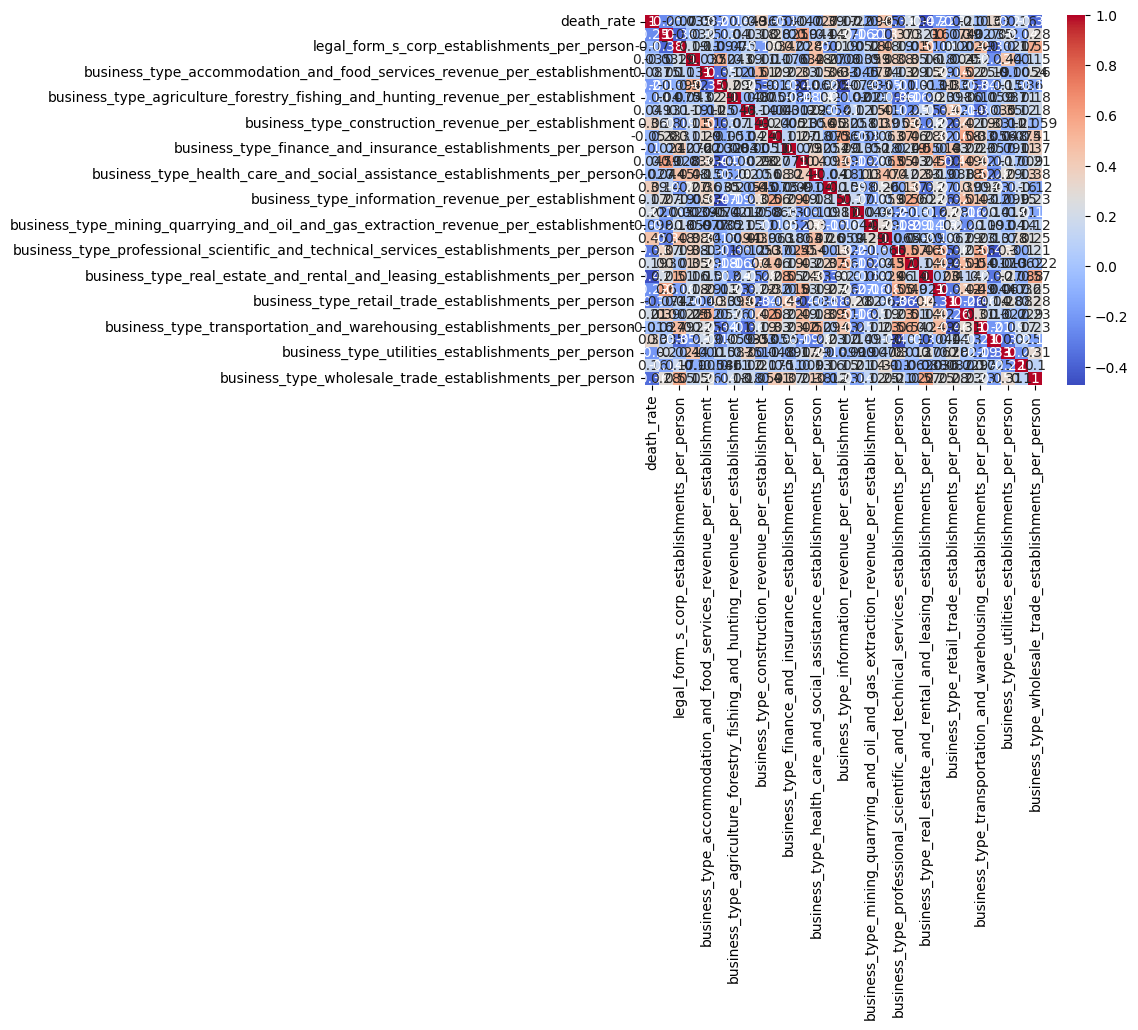

In [176]:
threshold = 0.6  # Set the threshold for collinearity

heart_disease_df = frames_by_cause_dict["Heart disease"]

candidate_feature_list = [x for x in heart_disease_df.columns if is_feature(x)]
non_collinear_feature_list = get_non_collinear_features(
    frame=heart_disease_df,
    feature_list=candidate_feature_list,
    threshold=threshold,
)
heart_disease_df = heart_disease_df[["death_rate"] + non_collinear_feature_list]
correlation_matrix = heart_disease_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [177]:
# Now that we have removed collinearity ...

X_column_list = list(heart_disease_df.columns)

ols_formula = "death_rate ~ "
ols_formula += " + ".join(X_column_list)
ordinary_least_square = ols(formula=ols_formula, data=heart_disease_df)
ordinary_least_square.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             death_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.246e+28
Date:                Mon, 15 Apr 2024   Prob (F-statistic):          7.58e-291
Time:                        13:37:31   Log-Likelihood:                 1415.7
No. Observations:                  51   AIC:                            -2771.
Df Residuals:                      21   BIC:                            -2713.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================================
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                       0   1.55e-12          0      1.000   -3.23e-12    3.23e-12
death_rate                                                                                 1.0000   4.24e-15   2.36e+14      0.000       1.000       1.000
legal_form_individual_proprietor_revenue_per_establishment                              2.274e-13   9.84e-13      0.231      0.820   -1.82e-12    2.27e-12
legal_form_s_corp_establishments_per_person                                            -1.137e-13   2.89e-12     -0.039      0.969   -6.13e-12     5.9e-12
business_type_accommodation_and_food_services_establishments_per_person                -3.638e-12   1.21e-11     -0.301      0.767   -2.88e-11    2.15e-11
business_type_accommodation_and_food_services_revenue_per_establishment                 5.351e-14   3.73e-13      0.143      0.887   -7.23e-13     8.3e-13
business_type_agriculture_forestry_fishing_and_hunting_establishments_per_person        2.274e-13   2.38e-12      0.095      0.925   -4.73e-12    5.18e-12
business_type_agriculture_forestry_fishing_and_hunting_revenue_per_establishment       -4.263e-14   5.13e-13     -0.083      0.935   -1.11e-12    1.02e-12
business_type_construction_establishments_per_person                                   -9.948e-14   1.29e-12     -0.077      0.939   -2.79e-12    2.59e-12
business_type_construction_revenue_per_establishment                                   -1.421e-14   6.49e-13     -0.022      0.983   -1.36e-12    1.34e-12
business_type_educational_services_revenue_per_establishment                           -2.842e-14   7.67e-13     -0.037      0.971   -1.62e-12    1.57e-12
business_type_finance_and_insurance_establishments_per_person                           2.274e-13   5.25e-12      0.043      0.966   -1.07e-11    1.11e-11
business_type_finance_and_insurance_revenue_per_establishment                          -2.274e-13   1.24e-12     -0.184      0.856    -2.8e-12    2.34e-12
business_type_health_care_and_social_assistance_establishments_per_person              -2.842e-13   2.35e-12     -0.121      0.905   -5.17e-12     4.6e-12
business_type_health_care_and_social_assistance_revenue_per_establishment              -8.171e-14    3.8e-13     -0.215      0.832   -8.73e-13    7.09e-13
business_type_information_revenue_per_establishment                                     8.527e-14   7.91e-13      0.108      0.915   -1.56e-12    1.73e-12
business_type_mining_quarrying_and_oil_and_gas_extraction_establishments_per_person    -2.274e-13   2.98e-12     -0.076      0.940   -6.43

### Overfitting/collinearity
It looks like we are still somewhat collinear, and we are probably overfitting, let's choose the most promising (based on P-score) five features.

In [179]:
refined_column_list = [
    "business_type_agriculture_forestry_fishing_and_hunting_revenue_per_establishment",
    "business_type_mining_quarrying_and_oil_and_gas_extraction_establishments_per_person",
    "business_type_professional_scientific_and_technical_services_establishments_per_person",
    "business_type_professional_scientific_and_technical_services_revenue_per_establishment",
    "business_type_retail_trade_revenue_per_establishment",
]

ols_formula = "death_rate ~ "
ols_formula += " + ".join(refined_column_list)
ordinary_least_square = ols(formula=ols_formula, data=heart_disease_df)
model = ordinary_least_square.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             death_rate   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     6.958
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           6.88e-05
Time:                        13:38:01   Log-Likelihood:                -227.55
No. Observations:                  51   AIC:                             467.1
Df Residuals:                      45   BIC:                             478.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================================
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                138.2420     30.247      4.570      0.000      77.322     199.162
business_type_agriculture_forestry_fishing_and_hunting_revenue_per_establishment         -41.4115     14.389     -2.878      0.006     -70.393     -12.430
business_type_mining_quarrying_and_oil_and_gas_extraction_establishments_per_person      164.7441    117.740      1.399      0.169     -72.397     401.885
business_type_professional_scientific_and_technical_services_establishments_per_person  -137.2558     28.519     -4.813      0.000    -194.697     -79.815
business_type_professional_scientific_and_technical_services_revenue_per_establishment    84.0511     30.095      2.793      0.008      23.437     144.666
business_type_retail_trade_revenue_per_establishment                                      57.5062     33.102      1.737      0.089      -9.165     124.177
==============================================================================
Omnibus:                        1.478   Durbin-Watson:                   0.989
Prob(Omnibus):                  0.478   Jarque-Bera (JB):                1.304
Skew:                           0.235   Prob(JB):                        0.521
Kurtosis:                       2.373   Cond. No.                         73.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Impacts of the selected features

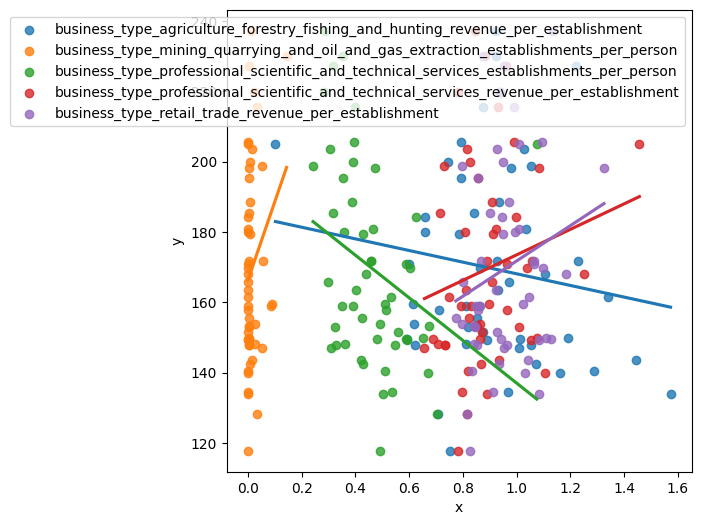

In [180]:
fig, ax = plt.subplots(figsize=(6, 6))
for feature in refined_column_list:
    sns.regplot(x=feature, y="death_rate", data=heart_disease_df, fit_reg=True, ci=None, ax=ax, label=feature)
ax.set(ylabel='y', xlabel='x')
ax.legend()

<a id='heart_disease_linear_regression_conclusion'></a>
### Conclusions
I'm going to ignore _business_type_mining_quarrying_and_oil_and_gas_extraction_establishments_per_person_ because the P value was pretty high.

- Positive correlation with revenue per professional, scientific and technical services establishment.
- Positive correlation with revenue per retail establishment.
- Inverse correlation with the revenue per agriculture, forestry, fishing and hunting establishment.
- Inverse correlation with the number of nonemployee professional, scientific and technical establishments per person

In other words, move to a state with good revenue from professional/scientific/technical services and retail establishments, and maybe avoid states with more revenue from agriculture, forestry, fishing and hunting establishment establishments.

### Verifying assumptions
At the beginning we stated assumptions for linear regression, so let's check:
* The residuals are at least somewhat normally distributed ...
* Our assumption of homoscedasticity is solid

Text(0.5, 0, 'Residual Value')

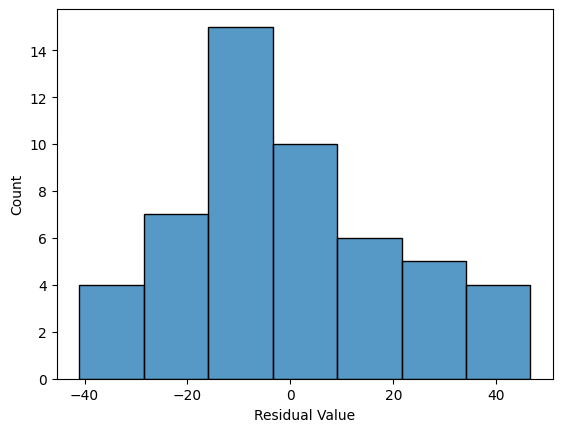

In [181]:
residuals = model.resid
fig = sns.histplot(residuals)
fig.set_xlabel("Residual Value")

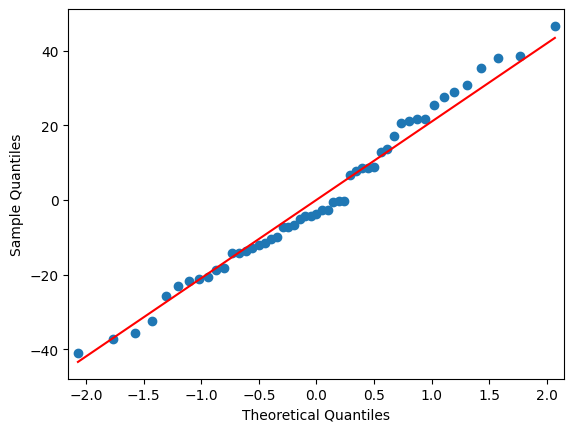

In [182]:
fig = qqplot(model.resid, line='s')
plt.show()

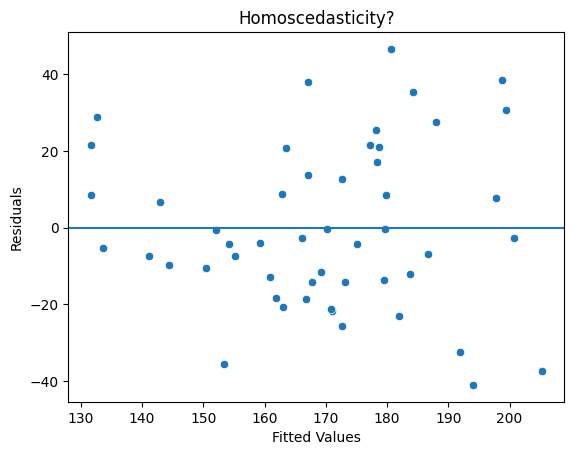

In [183]:
fitted_values = model.predict(heart_disease_df)
fig = sns.scatterplot(x=fitted_values, y=residuals)
fig.axhline(0)  # Reference line

fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
fig.set_title("Homoscedasticity?")

plt.show()